In [1]:
! pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=c25d79524ae8fa5d5b64f28b18cfca46ed18428ec7839d71e4cf664ca6711f70
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [2]:
from jcopdl.callback import Callback, set_config

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.init
import random
import numpy as np
import matplotlib.pyplot as plt


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 그래픽 카드를 쓸 수 있으면 device에 cuda가 입력된다.
# 그래픽 카드를 쓸 수 없으면 device에 cpu가 입력된다.

In [5]:
random.seed(164499)
torch.manual_seed(164499) #cpu 연산 무작위 고정
torch.cuda.manual_seed(164499) #gpu 연산 무작위 고정
torch.cuda.manual_seed_all(164499) #멀티 gpu 연산 무작위 고정
np.random.seed(164499) #numpy 관련 연산 무작위 고정

In [28]:
transforms_1 = transforms.Compose([transforms.RandomResizedCrop(size = 28, scale=(0.5 ,0.8), ratio=(0.5, 1.3)),transforms.ToTensor()])
transforms_2 = transforms.Compose([transforms.RandomRotation(degrees=180),transforms.ToTensor()])

mnist_RRC = dsets.MNIST(root='MNIST_data/', train=True,transform = transforms_1, download=True)

mnist_RR = dsets.MNIST(root='MNIST_data/', train=True,transform = transforms_2, download=True)
mnist_ADD = mnist_RR + mnist_RRC
mnist_ADD, mnist_ADD_1 = torch.utils.data.random_split(mnist_ADD, [60000,60000], generator=torch.Generator().manual_seed(164499))

mnist_train = dsets.MNIST(root='MNIST_data/', train=True,transform = transforms.ToTensor(), download=True)
mnist_train = mnist_train + mnist_ADD
           
mnist_test = dsets.MNIST(root='MNIST_data/', train=False,transform = transforms.ToTensor(), download=True)
        
              
#mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [100000,20000], generator=torch.Generator().manual_seed(164499))


In [7]:
batch_size = 128
learning_rate = 0.0003
training_epochs = 300
patience = 45

config = set_config(dict(output_size=100, batch_size = batch_size, image_size = (28, 28),
                         lr = learning_rate))

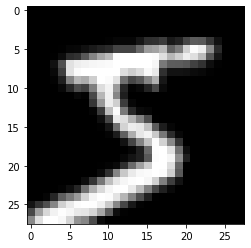

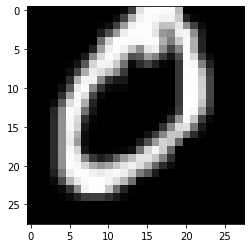

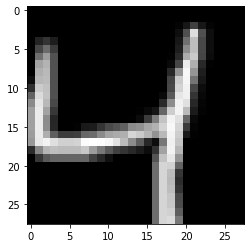

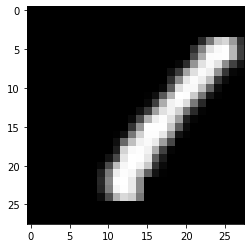

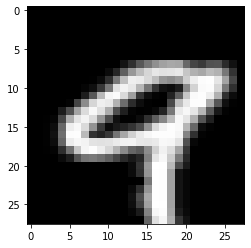

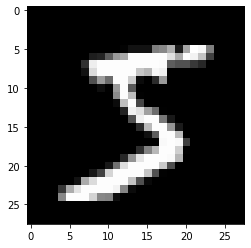

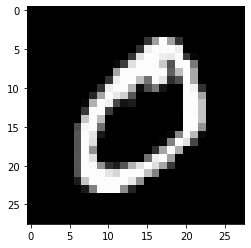

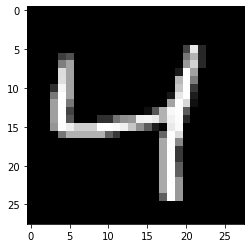

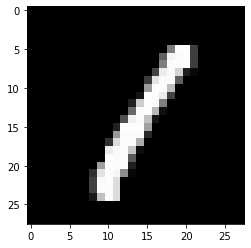

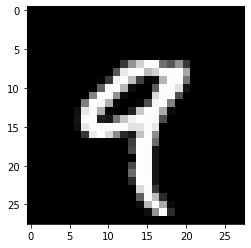

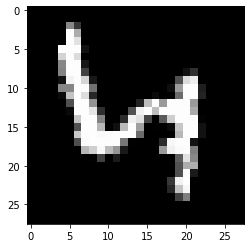

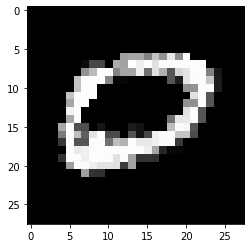

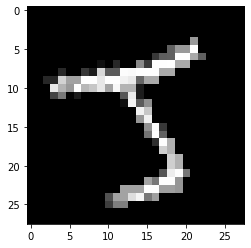

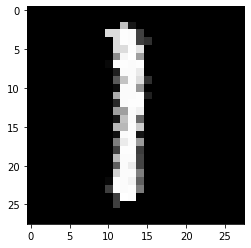

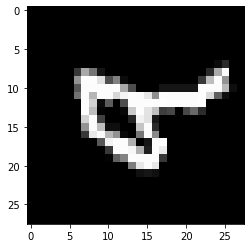

In [30]:
#for i in range(10):
#  plt.imshow(mnist_RRC[i][0].numpy().reshape(28,28), cmap='gray')
#  plt.pause(0.01)

for i in range(5):
  plt.imshow(mnist_RRC[i][0].numpy().reshape(28,28), cmap='gray')
  plt.pause(0.01)

print("===============================================")
for i in range(5):
  plt.imshow(mnist_train[i][0].numpy().reshape(28,28), cmap='gray')
  plt.pause(0.01)  
print("===============================================")
for i in range(5):
  plt.imshow(mnist_RR[i][0].numpy().reshape(28,28), cmap='gray')
  plt.pause(0.01)


plt.show()

#plt.imshow(mnist_val[10][0].numpy().reshape(28,28), cmap='gray')
#print(mnist_train[10][3])    #10번째 데이터의 레이블 출력(3)
#plt.show()



In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           worker_init_fn=np.random.seed(164499),
                                           batch_size = batch_size,
                                          #  shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=mnist_val,
                                          worker_init_fn=np.random.seed(164499),                                         
                                          batch_size = len(mnist_val),
                                          # shuffle=True,
                                          drop_last=True)

# drop last는 배치사이즈로 나누고 남은 데이터들을 버리냐에 대한 옵션

In [ ]:
class CNN(nn.Module):
#############   직접 코드를 작성해보시기 바랍니다.  #############
  def __init__(self, p) :
    super(CNN, self).__init__()
    self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), #1*28*28 -> 32*(26+1)*(26+1)
        nn.BatchNorm2d(32),        
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2) #32*13*13
    )

    self.drop_layer = nn.Dropout2d(p=p)

    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1), #32*13*13 -> 64*(11+1)*(11+1)
        nn.BatchNorm2d(64),              
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2), #64*7*7  
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), #64*7*7 -> 128*(5+1)*(5+1)
        nn.BatchNorm2d(128),      
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2) #128*6*6 -> 128*3*3
    )

    self.fc = torch.nn.Linear(3*3*128,10, bias=True)
    torch.nn.init.kaiming_normal_(self.fc.weight) 
  
  def forward(self,x):
    out = self.layer1(x)  #100개의 노드로 출력
    # out = self.drop_layer(out)
    out = self.layer2(out)
    # out = self.drop_layer(out)
    out = self.layer3(out)
    # out = self.drop_layer(out)        
    out = out.view(out.size(0), -1) #fc층에 넣기 위해 다시 펼쳐준다.
    out = self.fc(out)
    return out

#################################################################

In [ ]:
#모델을 만들어서 gpu로 보낸다.
# model = FC().to(device)
model = CNN(p=0.3).to(device)

In [ ]:
#목적함수, 최적화방법 설정
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
callback = Callback(model, config, early_stop_patience=patience, outdir='model') 

In [ ]:
class ModelTrainer() :
  
  def __init__(self, model, optimizer, criterion, device, callback) :
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.device = device
    self.callback = callback

  def train(self, train_loader, val_loader, epochs) :
    total_batch = len(train_loader)
    
    for epoch in range(epochs):
      
      train_cost = 0
      val_cost = 0

      for X, Y in train_loader :
        X = X.to(device) #gpu 연산을 위해 device로 보내줘야 한다.
        Y = Y.to(device)
        optimizer.zero_grad()
        hypothesis = model(X)
  
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        train_cost += cost/total_batch
      
      for X, Y in val_loader :
        X = X.to(device) #gpu 연산을 위해 device로 보내줘야 한다.
        Y = Y.to(device)
        hypothesis = model(X)
  
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        val_cost += cost/1

      print('\n\n[Epoch: {:>4} train_cost = {:>.9} val_cost = {:>.9}'.format(epoch+1,train_cost, val_cost))

      self.callback.log(train_cost, val_cost)
      self.callback.save_checkpoint()      
      if self.callback.early_stopping(model, monitor= 'test_cost') :
        self.callback.plot_cost()
        break

In [ ]:
model_trainer = ModelTrainer(model, optimizer, criterion, device, callback)

In [ ]:
model_trainer.train(train_loader, val_loader, training_epochs)



[Epoch:    1 train_cost = 0.38498953 val_cost = 0.195088178

Epoch     1
Train_cost  = 0.3850 | Test_cost  = 0.1951 | 


[Epoch:    2 train_cost = 0.158808857 val_cost = 0.13438639

Epoch     2
Train_cost  = 0.1588 | Test_cost  = 0.1344 | 


[Epoch:    3 train_cost = 0.11741031 val_cost = 0.110095181

Epoch     3
Train_cost  = 0.1174 | Test_cost  = 0.1101 | 


In [ ]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    # print(torch.argmax(prediction,1))
    correct_prediction = torch.argmax(prediction,1)==Y_test
    accuracy = correct_prediction.float().mean()
    print("Accuracy: ", accuracy.item())
    